### Exploratory Data Analysis and ACO Modelling

In this notebook we will use the pandas generated dataset and use Graph Algorithms to find the best route.
Using this as our baseline model we will be able to compare improvements in the model's performance as we proceed to ACO and Amoeba TSP, then construct our hybrid model with hyperparameter tuning for comparison with all results.
We will test for underfitting and overfitting as we proceed and adjust where need be.

In [53]:
# Load necessary libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [54]:
# Read csv data
df = pd.read_csv('optimized_transport_data.csv')

In [55]:
# View the first 5 rows of the dataframe
df.head()

,City of Origin,Destination City,Stopover City,Vehicle Plate,Distance (km),Vehicle Type,Speed (km/h),Fuel Consumption (L/100km),Traffic Congestion,Adjusted Speed (km/h),Travel Time (hours),Total Fuel Consumption (L),Peak Time,Off-Peak Time,Free-Flow Speed (km/h),Free-Flow Time (hours),Travel Time Index (TTI),Load Weight (pounds)
0,Nairobi,Kisumu,NaN,NAI-KIS-0000,341.0,Coupe,72.315494,16.788811,High,52.315494,6.518146,57.249847,7.829561,5.710669,130,2.623077,2.484924,718.438353
1,Bujumbura,Gitega,NaN,BUJ-GIT-0001,98.9,Hybrid,58.895994,5.902852,Medium,58.895994,1.679231,5.837921,2.011070,1.214930,100,0.989000,1.697908,805.418495
2,Nairobi,Bujumbura,NaN,NAI-BUJ-0002,1281.0,Saloon,78.107674,11.786449,High,58.107674,22.045281,150.984407,25.848074,17.530530,110,11.645455,1.893037,689.438151
3,Kampala,Kigali,NaN,KAM-KIG-0003,511.0,Hybrid,41.858236,6.924270,Medium,41.858236,12.207872,35.383018,14.344186,10.196452,100,5.110000,2.389016,814.233168
4,Kisumu,Bujumbura,NaN,KIS-BUJ-0004,1064.0,Hybrid,41.967992,7.942348,Low,61.967992,17.170154,84.506580,20.367696,15.099745,100,10.640000,1.613736,940.969123


# Data Dictionary: Sub-Saharan Transport Dataset

This dataset contains 1000 records of vehicle travel data across different cities in Sub-Saharan Africa. It includes information on city pairs, vehicle characteristics, traffic congestion, and travel-related metrics.

## Columns and Descriptions

### **1. City of Origin** (`string`)
   - The starting city of the trip.
   - Example: `"Kigali"`

### **2. Destination City** (`string`)
   - The final city where the vehicle is traveling.
   - Example: `"Butare"`

### **3. Stopover City** (`string, nullable`)
   - An intermediate city where the vehicle may make a stop before reaching the final destination.
   - If no stopover exists, the value is `null`.
   - Example: `"Arusha"` or `null`

### **4. Vehicle Plate** (`string, unique identifier`)
   - A unique identifier for each vehicle in the format: `"XXX-XXX-####"`
   - The first three characters represent the first three letters of the origin city, the next three represent the destination city, followed by a four-digit serial number.
   - Example: `"KIG-BUT-0001"`

### **5. Vehicle Type** (`categorical`)
   - The type of vehicle used for the trip.
   - Possible values:
     - `"SUV"`
     - `"Truck"`
     - `"Saloon"`
     - `"Coupe"`
     - `"Hybrid"`
   - Example: `"Truck"`

### **6. Speed (km/h)** (`float`)
   - The average speed of the vehicle during travel.
   - Speed varies depending on the vehicle type.
   - Example: `85.4`

### **7. Load Weight (tons)** (`float`)
   - The weight of the cargo or passengers carried by the vehicle.
   - Example: `3.2`

### **8. Fuel Consumption (L/100km)** (`float`)
   - The amount of fuel consumed by the vehicle per 100 km.
   - Example: `12.5`

### **9. Traffic Congestion** (`categorical`)
   - The level of traffic congestion during the trip.
   - Possible values:
     - `"Low"`
     - `"Medium"`
     - `"High"`
   - Example: `"High"`

### **10. Driving Distance (km)** (`float`)
   - The precomputed driving distance between the origin and destination city.
   - Derived from Google Maps data.
   - Example: `125.0`

### **11. Travel Time (hours)** (`float`)
   - The estimated time taken to travel based on speed and driving distance.
   - Calculated as:  
     \[
     \text{Travel Time} = \frac{\text{Driving Distance}}{\text{Speed}}
     \]
   - Example: `2.5`

### **12. Adjusted Travel Time (hours)** (`float`)
   - The estimated travel time after accounting for traffic congestion.
   - Speed is adjusted by ±20 km/h based on traffic:
     - `"Low"` congestion: Speed increases by 20 km/h.
     - `"High"` congestion: Speed decreases by 20 km/h.
     - `"Medium"` congestion: No change.
   - Example: `2.8`

### **13. Peak Time Indicator** (`boolean`)
   - Indicates whether the travel occurs during peak hours.
   - Peak hours are derived from the adjusted travel time.
   - `True` if the trip overlaps with typical peak hours, otherwise `False`.
   - Example: `True`

### **14. Off-Peak Time Indicator** (`boolean`)
   - Indicates whether the travel occurs during off-peak hours.
   - Off-peak hours are derived from the adjusted travel time.
   - Example: `False`

### **15. Travel Time Index** (`float`)
   - A measure of traffic efficiency calculated as:
     \[
     \text{Travel Time Index} = \frac{\text{Adjusted Travel Time}}{\text{Travel Time}}
     \]
   - A value greater than `1.0` indicates congestion delays.
   - Example: `1.12`


In [57]:
# Check for Nil values and dtype of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   City of Origin              10000 non-null  object 
 1   Destination City            10000 non-null  object 
 2   Stopover City               1869 non-null   object 
 3   Vehicle Plate               10000 non-null  object 
 4   Distance (km)               10000 non-null  float64
 5   Vehicle Type                10000 non-null  object 
 6   Speed (km/h)                10000 non-null  float64
 7   Fuel Consumption (L/100km)  10000 non-null  float64
 8   Traffic Congestion          10000 non-null  object 
 9   Adjusted Speed (km/h)       10000 non-null  float64
 10  Travel Time (hours)         10000 non-null  float64
 11  Total Fuel Consumption (L)  10000 non-null  float64
 12  Peak Time                   10000 non-null  float64
 13  Off-Peak Time               1000

In [58]:
# Impute the destination city values to the nan stopover rows values

df['Stopover City'].fillna(df['Destination City'], inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12428\3464706842.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Stopover City'].fillna(df['Destination City'], inplace=True)


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   City of Origin              10000 non-null  object 
 1   Destination City            10000 non-null  object 
 2   Stopover City               10000 non-null  object 
 3   Vehicle Plate               10000 non-null  object 
 4   Distance (km)               10000 non-null  float64
 5   Vehicle Type                10000 non-null  object 
 6   Speed (km/h)                10000 non-null  float64
 7   Fuel Consumption (L/100km)  10000 non-null  float64
 8   Traffic Congestion          10000 non-null  object 
 9   Adjusted Speed (km/h)       10000 non-null  float64
 10  Travel Time (hours)         10000 non-null  float64
 11  Total Fuel Consumption (L)  10000 non-null  float64
 12  Peak Time                   10000 non-null  float64
 13  Off-Peak Time               1000

In [60]:
# Check the unique values of the Stopover column

unique_stopovers = df["Stopover City"].unique()
print(unique_stopovers)

['Kisumu' 'Gitega' 'Bujumbura' 'Kigali' 'Kampala' 'Nairobi' 'Arusha'
 'Mombasa' 'Wau' 'Juba' 'Dar es Salaam']


### Univariate, Bivariate and Multivariate Analysis


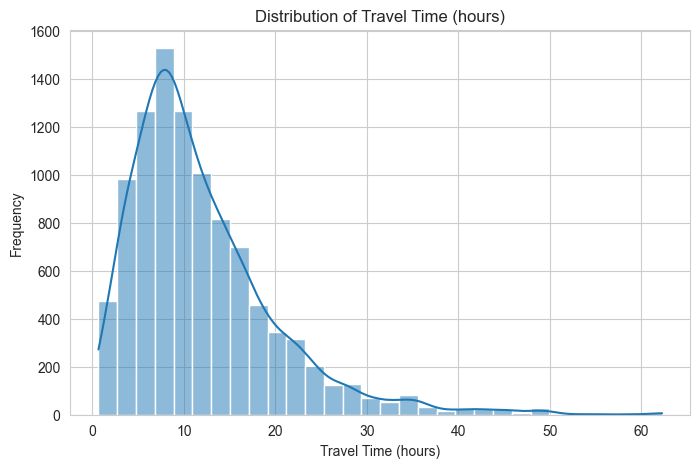

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12428\54707617.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Vehicle Type", palette="coolwarm")


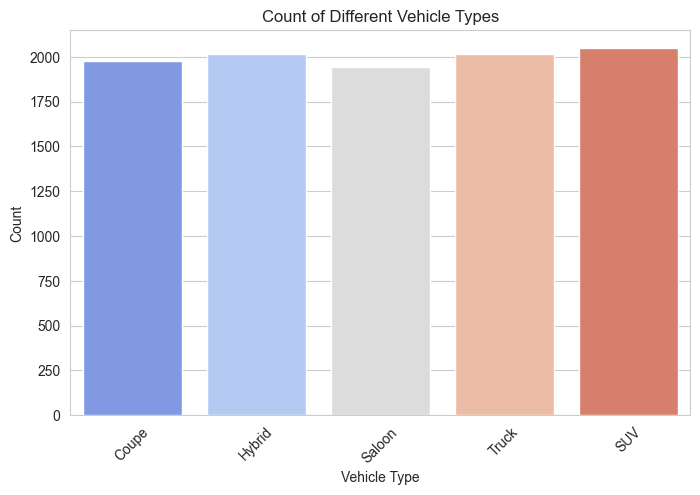

In [62]:
# Distribution of Travel Time (hours)
plt.figure(figsize=(8, 5))
sns.histplot(df["Travel Time (hours)"], bins=30, kde=True)
plt.title("Distribution of Travel Time (hours)")
plt.xlabel("Travel Time (hours)")
plt.ylabel("Frequency")
plt.show()

# Count plot for vehicle types
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Vehicle Type", palette="coolwarm")
plt.title("Count of Different Vehicle Types")
plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

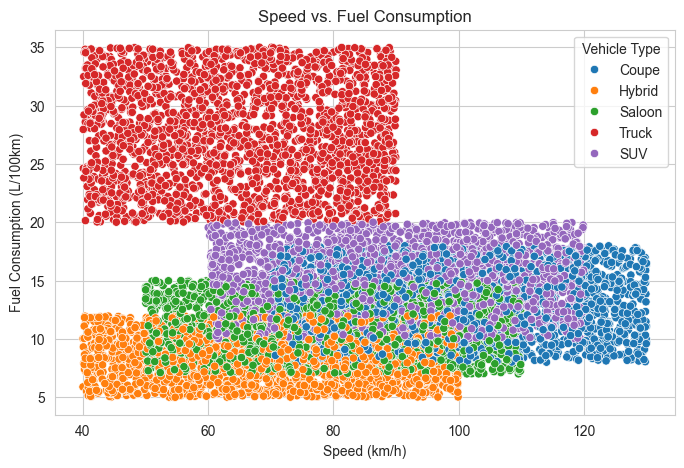

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12428\158382961.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Traffic Congestion", y="Travel Time (hours)", palette="coolwarm")


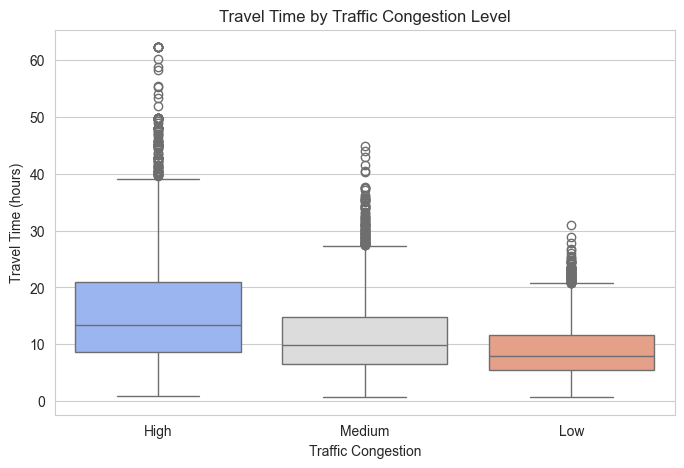

In [63]:
# Scatter plot: Speed vs. Fuel Consumption
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Speed (km/h)", y="Fuel Consumption (L/100km)", hue="Vehicle Type")
plt.title("Speed vs. Fuel Consumption")
plt.xlabel("Speed (km/h)")
plt.ylabel("Fuel Consumption (L/100km)")
plt.show()

# Box plot: Travel Time by Traffic Congestion Level
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Traffic Congestion", y="Travel Time (hours)", palette="coolwarm")
plt.title("Travel Time by Traffic Congestion Level")
plt.xlabel("Traffic Congestion")
plt.ylabel("Travel Time (hours)")
plt.show()

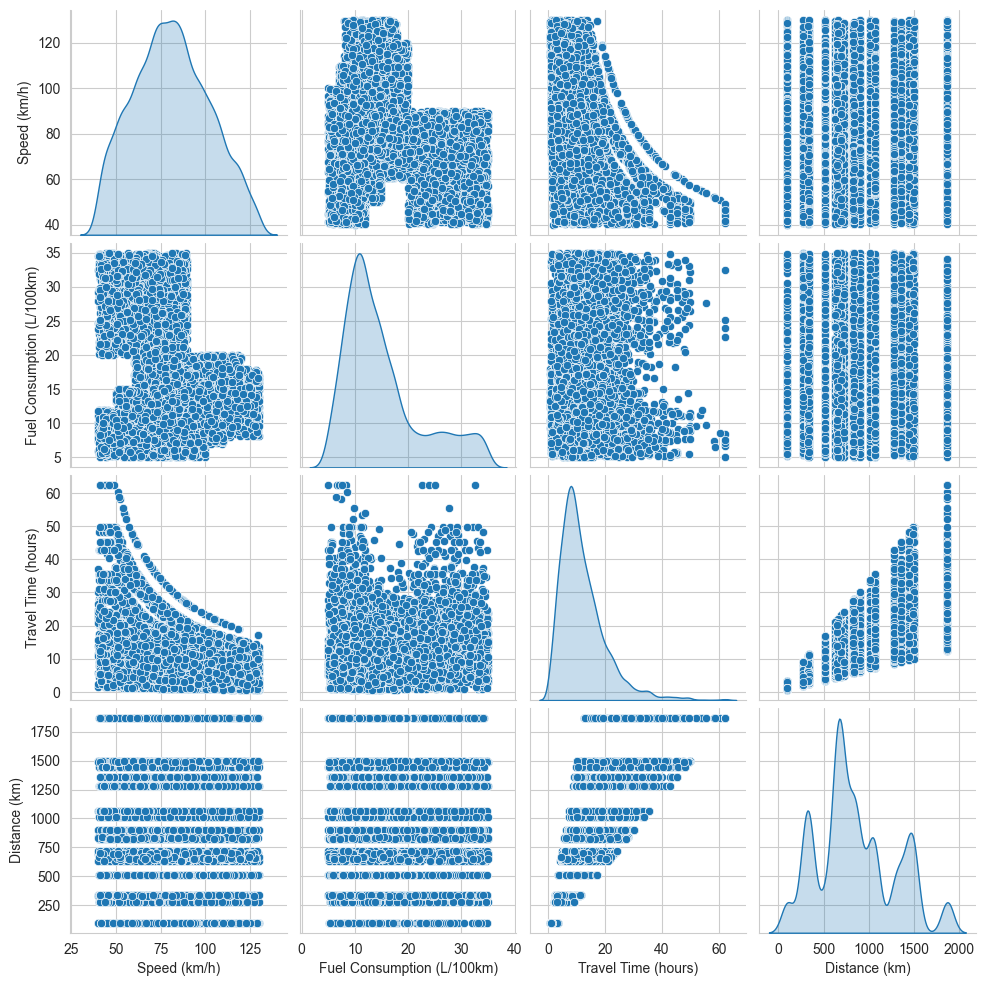

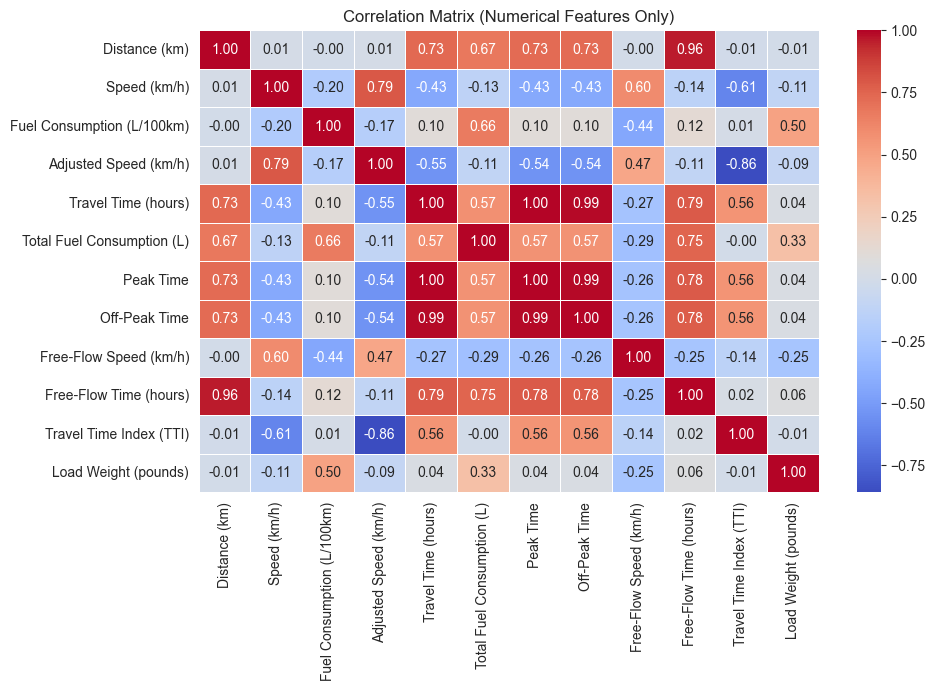

In [64]:
# Pairplot of numerical features
sns.pairplot(df[["Speed (km/h)", "Fuel Consumption (L/100km)", "Travel Time (hours)", "Distance (km)"]], diag_kind="kde")
plt.show()

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features Only)")
plt.show()

### Check For Skewness, Kurtosis and Normality

I'll use scipy library to perform tests on the data set to unsure uniformity in the dataset.

In [66]:
from scipy.stats import skew, kurtosis, shapiro, anderson, normaltest

# Select numerical columns
num_cols = ["Speed (km/h)", "Fuel Consumption (L/100km)", "Travel Time (hours)", "Distance (km)"]

# Create a DataFrame to store test results
results = pd.DataFrame(columns=["Skewness", "Kurtosis", "Shapiro-Wilk p-value", "Anderson-Darling Stat", "D'Agostino p-value"])

for col in num_cols:
    skewness = skew(df[col])
    kurt = kurtosis(df[col])
    shapiro_p = shapiro(df[col])[1]  # Extract p-value
    anderson_stat = anderson(df[col]).statistic
    dagostino_p = normaltest(df[col])[1]  # Extract p-value
    
    results.loc[col] = [skewness, kurt, shapiro_p, anderson_stat, dagostino_p]

# Print results
print(results)


                            Skewness  Kurtosis  Shapiro-Wilk p-value  \
Speed (km/h)                0.148454 -0.685818          2.657708e-30   
Fuel Consumption (L/100km)  1.099591  0.355467          0.000000e+00   
Travel Time (hours)         1.688818  4.435154          0.000000e+00   
Distance (km)               0.448566 -0.408655          0.000000e+00   

                            Anderson-Darling Stat  D'Agostino p-value  
Speed (km/h)                            21.262415       1.979596e-115  
Fuel Consumption (L/100km)             395.945590       3.012986e-305  
Travel Time (hours)                    268.330266        0.000000e+00  
Distance (km)                          158.813429        1.524087e-91  


C:\Users\ADMIN\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\ADMIN\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\ADMIN\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\ADMIN\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### None of the variables follow a normal distribution.
1. Travel Time and Fuel Consumption are highly non-normal, indicating possible outliers or an exponential-like distribution.
2. Distance and Speed are closer to normal but still show deviation.
3. If normality is required for modeling, consider log transformation or Box-Cox transformation to reduce skewness. 🚀

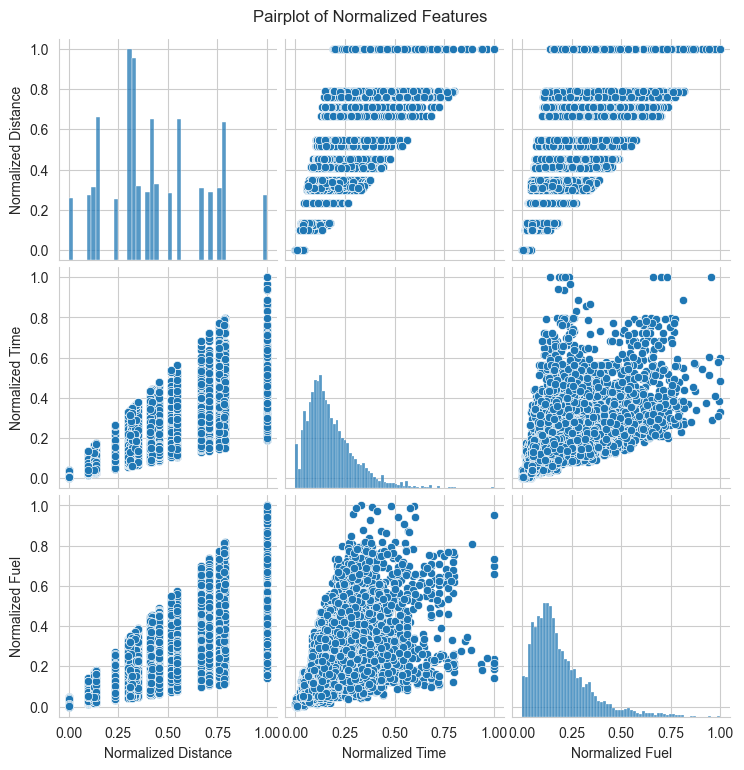

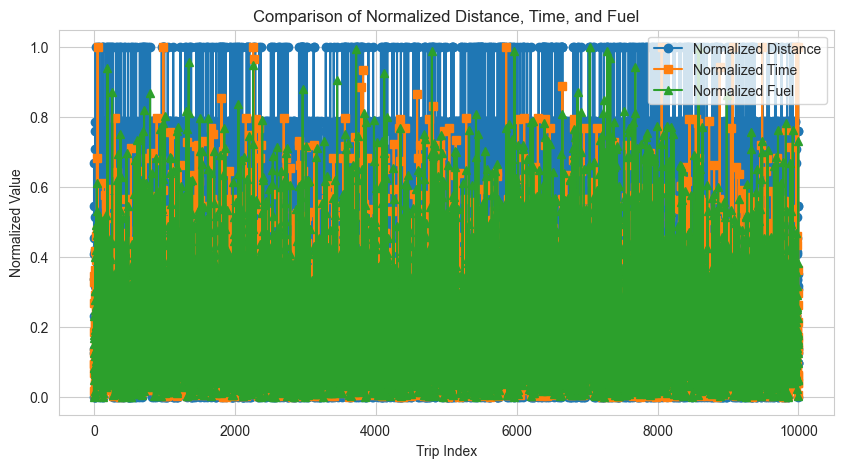

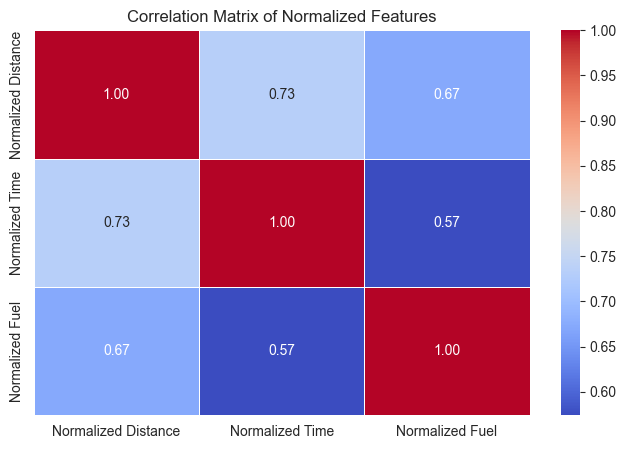

In [68]:
# Feature Engineering for the ACO

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Normalized Distance', 'Normalized Time', 'Normalized Fuel']] = scaler.fit_transform(
    df[['Distance (km)', 'Travel Time (hours)', 'Total Fuel Consumption (L)']]
)

# 📌 Set plot style
sns.set_style("whitegrid")

# 📊 1️⃣ Pairplot to Show Distributions
sns.pairplot(df[['Normalized Distance', 'Normalized Time', 'Normalized Fuel']])
plt.suptitle("Pairplot of Normalized Features", y=1.02)
plt.show()

# 📊 2️⃣ Line Plot to Compare Trends
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Normalized Distance'], label="Normalized Distance", marker='o')
plt.plot(df.index, df['Normalized Time'], label="Normalized Time", marker='s')
plt.plot(df.index, df['Normalized Fuel'], label="Normalized Fuel", marker='^')
plt.xlabel("Trip Index")
plt.ylabel("Normalized Value")
plt.title("Comparison of Normalized Distance, Time, and Fuel")
plt.legend()
plt.show()

# 📊 3️⃣ Heatmap to Show Correlations
plt.figure(figsize=(8, 5))
sns.heatmap(df[['Normalized Distance', 'Normalized Time', 'Normalized Fuel']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Normalized Features")
plt.show()

### Feature Engineering for The Network Graph
Create a Weighted Cost Function for ACO where ACO selects routes based on pheromone trails, which should favor efficient paths.

In [70]:
# Define weights for distance, time, and fuel
ALPHA, BETA, GAMMA = 0.4, 0.2, 0.4

# Compute Edge Score based on distance, time, and fuel efficiency
df['Edge Score'] = (
    ALPHA * df['Normalized Distance'] +
    BETA * df['Normalized Time'] +
    GAMMA * df['Normalized Fuel']
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   City of Origin              10000 non-null  object 
 1   Destination City            10000 non-null  object 
 2   Stopover City               10000 non-null  object 
 3   Vehicle Plate               10000 non-null  object 
 4   Distance (km)               10000 non-null  float64
 5   Vehicle Type                10000 non-null  object 
 6   Speed (km/h)                10000 non-null  float64
 7   Fuel Consumption (L/100km)  10000 non-null  float64
 8   Traffic Congestion          10000 non-null  object 
 9   Adjusted Speed (km/h)       10000 non-null  float64
 10  Travel Time (hours)         10000 non-null  float64
 11  Total Fuel Consumption (L)  10000 non-null  float64
 12  Peak Time                   10000 non-null  float64
 13  Off-Peak Time               1000

Construct a graph where each city is a node and each route is an edge with Edge Score as the weight.

In [72]:
import networkx as nx

# Create a Graph using networkx
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['City of Origin'], row['Destination City'], weight=row['Edge Score'])


Create a layout for better spacing, draw the network and include both the edge weights and label the nodes.

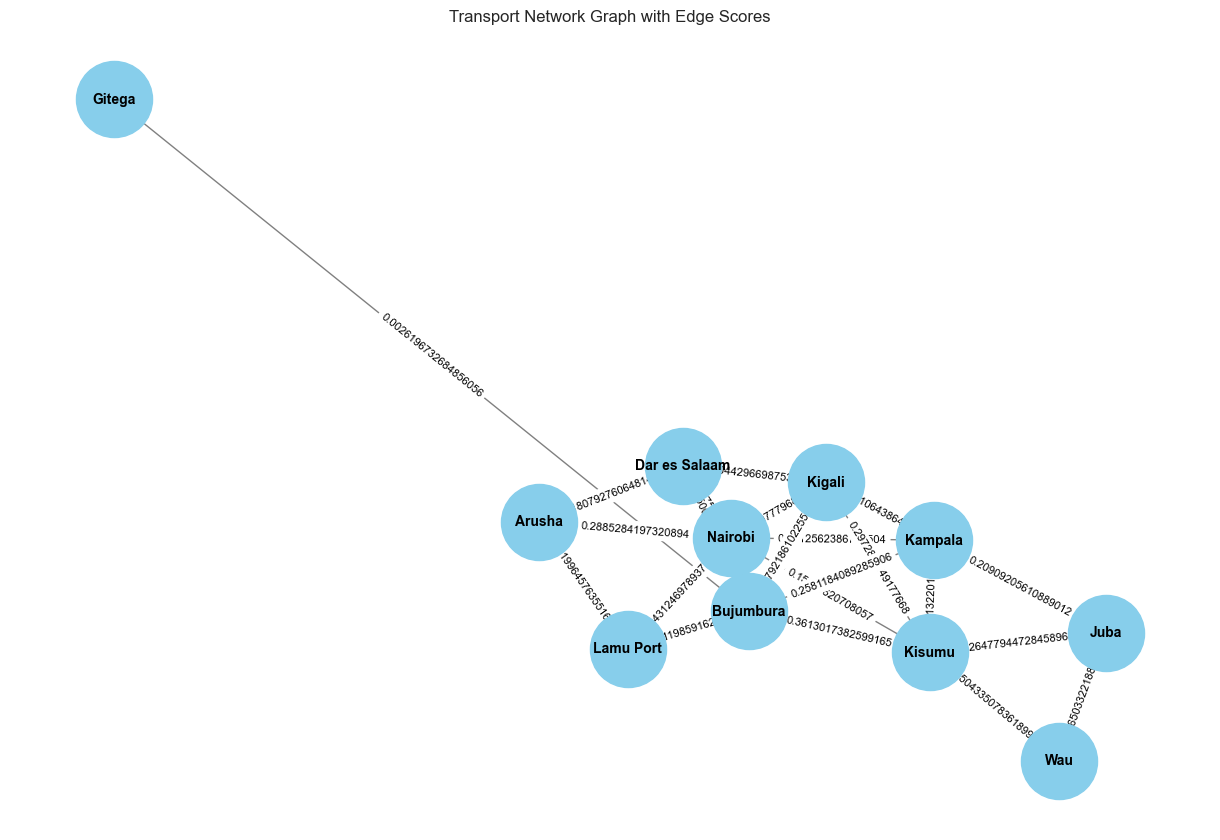

{('Nairobi', 'Kisumu'): 0.15403620708057, ('Nairobi', 'Bujumbura'): 0.412752336088938, ('Nairobi', 'Lamu Port'): 0.23431246978937395, ('Nairobi', 'Arusha'): 0.2885284197320894, ('Nairobi', 'Dar es Salaam'): 0.366671753452134, ('Nairobi', 'Kampala'): 0.2012562386781504, ('Nairobi', 'Kigali'): 0.4875077796879005, ('Kisumu', 'Bujumbura'): 0.3613017382599165, ('Kisumu', 'Kampala'): 0.07874132201877415, ('Kisumu', 'Wau'): 0.5043350783618993, ('Kisumu', 'Juba'): 0.26477944728458963, ('Kisumu', 'Kigali'): 0.2972811149177668, ('Bujumbura', 'Gitega'): 0.0026196732684856056, ('Bujumbura', 'Lamu Port'): 0.8931198591626672, ('Bujumbura', 'Kigali'): 0.06792186102255544, ('Bujumbura', 'Dar es Salaam'): 0.5002356626534006, ('Bujumbura', 'Kampala'): 0.2581184089285906, ('Kampala', 'Kigali'): 0.15081064386478962, ('Kampala', 'Juba'): 0.20909205610889012, ('Kigali', 'Dar es Salaam'): 0.43044296698753176, ('Lamu Port', 'Arusha'): 0.2199645763551628, ('Arusha', 'Dar es Salaam'): 0.21807927606481414, ('Wau

In [74]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a layout for better spacing
pos = nx.spring_layout(G, seed=42)  # Adjust layout for clear visualization

# Draw the network graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")

# Get edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# Draw edge labels (Edge Score)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=8)

plt.title("Transport Network Graph with Edge Scores")
plt.show()
print(edge_weights)


In [75]:
# Save the DataFrame to a CSV file
df.to_csv("transport_data_output.csv", index=False)
# Confirm it's saved
print("✅ CSV file saved as 'transport_data_output.csv'")


✅ CSV file saved as 'transport_data_output.csv'


In [76]:
def calculate_total_distance_from_path(df, path):
    """✅ NEW: Accurately sums distances along the route based on the DataFrame."""
    total_distance = 0
    for i in range(len(path) - 1):
        city_a, city_b = path[i], path[i+1]
        # Try to get a matching row (either direction)
        match = df[((df['City of Origin'] == city_a) & (df['Destination City'] == city_b)) |
                   ((df['City of Origin'] == city_b) & (df['Destination City'] == city_a))]

        if not match.empty:
            total_distance += match.iloc[0]['Distance (km)']
        else:
            print(f"⚠️ Missing distance data between {city_a} and {city_b}")
    return total_distance


def find_best_route(G, edge_weights, start, destination):
    """Finds the best route between two cities using shortest path."""
    try:
        path = nx.shortest_path(G, source=start, target=destination, weight='weight')
        
        # ✅ Replaced inaccurate distance estimation with proper route calculation
        total_distance = calculate_total_distance_from_path(df, path)
        return path, total_distance

    except (nx.NetworkXNoPath, nx.NodeNotFound):
        print("No valid route found. Check the city names!")
        return None, None


def recommend_top_vehicles(model, df, edge_weights, G):
    """Combines all steps to recommend the best vehicles for a journey."""
    start, destination, load_weight = get_user_input()
    if not start or not destination:
        return

    best_path, total_distance = find_best_route(G, edge_weights, start, destination)
    if not best_path:
        return

    top_vehicles = rank_vehicles(df, model, total_distance, load_weight)
    if not top_vehicles:
        return

    plot_route(G, best_path, top_vehicles)

    # ✅ Print updated route and correct total distance
    print(f"Best Route: {' → '.join(best_path)}")
    print(f"Total Distance: {total_distance:.2f} km")
    print(f"🚗 Recommended Vehicles (ranked): {', '.join(top_vehicles)}")


In [77]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🔄 Load data
df = pd.read_csv("optimized_transport_data.csv")  # Make sure this CSV exists

# 🔧 Feature Engineering: Normalize key metrics
scaler = MinMaxScaler()
df[['Normalized Distance', 'Normalized Time', 'Normalized Fuel']] = scaler.fit_transform(
    df[['Distance (km)', 'Travel Time (hours)', 'Total Fuel Consumption (L)']]
)

# ⚖️ Compute Edge Score (used for graph edge weights)
alpha, beta, gamma = 0.4, 0.2, 0.4
df['Edge Score'] = (
    alpha * df['Normalized Distance'] +
    beta * df['Normalized Time'] +
    gamma * df['Normalized Fuel']
)

# 🌍 Create network graph from transport data
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['City of Origin'], row['Destination City'], weight=row['Edge Score'])

# 🔁 Define helper to calculate distance over a full path
def calculate_total_distance_from_path(df, path):
    total = 0
    for i in range(len(path) - 1):
        leg = df[
            ((df['City of Origin'] == path[i]) & (df['Destination City'] == path[i+1])) |
            ((df['City of Origin'] == path[i+1]) & (df['Destination City'] == path[i]))
        ]
        if not leg.empty:
            total += leg['Distance (km)'].mean()
    return total

# 🧭 Dijkstra: Find shortest route and use total distance
start_city = "Nairobi"
end_city = "Juba"
dijkstra_path = nx.shortest_path(G, source=start_city, target=end_city, weight="weight")
total_dijkstra_distance = calculate_total_distance_from_path(df, dijkstra_path)
print("Best Path (Dijkstra):", " → ".join(dijkstra_path))
print(f"Total Distance: {total_dijkstra_distance:.2f} km")

# 🚗 Machine Learning: Predict vehicle type
features = ["Speed (km/h)", "Fuel Consumption (L/100km)", "Travel Time (hours)", "Distance (km)", "Load Weight (pounds)"]
X = df[features]
y = df["Vehicle Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Random Forest + Tuning
model = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
grid = GridSearchCV(model, params, cv=3)
grid.fit(X_train, y_train)

# 📈 Evaluate
y_pred = grid.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Best Parameters:", grid.best_params_)


Best Path (Dijkstra): Nairobi → Kampala → Juba
Total Distance: 1316.00 km
Model Accuracy: 0.806
              precision    recall  f1-score   support

       Coupe       0.85      0.67      0.75       400
      Hybrid       0.67      0.82      0.74       416
         SUV       0.99      0.99      0.99       380
      Saloon       0.56      0.54      0.55       389
       Truck       1.00      1.00      1.00       415

    accuracy                           0.81      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.81      0.81      0.81      2000

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


In [78]:
import pickle

with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)